In [47]:
#https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [48]:
df = pd.read_csv('flightData2.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (22062, 12)


,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
column type,int64,object,int64,object,object,float64,int64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,492,0,15629,15629,15629,15629,15629
null values (%),0,0,0,0,0,2.23008,0,70.8413,70.8413,70.8413,70.8413,70.8413


In [49]:
df.head()

,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,DL,370,ATL,EWR,-4.0,0,NaN,NaN,NaN,NaN,NaN
1,1,DL,384,ATL,EWR,4.0,0,NaN,NaN,NaN,NaN,NaN
2,1,DL,668,DTW,EWR,0.0,0,NaN,NaN,NaN,NaN,NaN
3,1,DL,690,EWR,DTW,-10.0,0,NaN,NaN,NaN,NaN,NaN
4,1,DL,807,EWR,ATL,-5.0,0,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.fillna({'CARRIER_DELAY': 0})
df = df.fillna({'DEP_DELAY': 0})
df = df.fillna({'WEATHER_DELAY': 0})
df = df.fillna({'NAS_DELAY': 0})
df = df.fillna({'SECURITY_DELAY': 0})
df = df.fillna({'LATE_AIRCRAFT_DELAY': 0})

In [8]:
#df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])

In [9]:
df.isnull().values.any()

False

In [10]:
df.head()

,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,DL,370,ATL,EWR,-4.0,0,0.0,0.0,0.0,0.0,0.0
1,1,DL,384,ATL,EWR,4.0,0,0.0,0.0,0.0,0.0,0.0
2,1,DL,668,DTW,EWR,0.0,0,0.0,0.0,0.0,0.0,0.0
3,1,DL,690,EWR,DTW,-10.0,0,0.0,0.0,0.0,0.0,0.0
4,1,DL,807,EWR,ATL,-5.0,0,0.0,0.0,0.0,0.0,0.0


In [11]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEP_DELAY'].groupby(df['OP_UNIQUE_CARRIER']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
OP_UNIQUE_CARRIER,,,,
G4,52.0,357.0,17.846154,-17.0
MQ,62.0,224.0,32.016129,-13.0
OO,72.0,203.0,12.236111,-12.0
9E,250.0,237.0,31.456000,-26.0
F9,408.0,257.0,15.691176,-20.0
AS,645.0,291.0,14.719380,-25.0
DL,837.0,665.0,18.408602,-17.0
WN,966.0,413.0,17.650104,-11.0
AA,1162.0,899.0,14.270224,-14.0


In [12]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,OP_UNIQUE_CARRIER,AIRLINE
0,G4,Allegiant Air
1,MQ,Envoy Air
2,OO,SkyWest
3,9E,Endeavor Air
4,F9,Frontier Flight
5,AS,Alaska Airlines
6,DL,Delta Air
7,WN,SouthWest
8,AA,American
9,NK,Spirit Airlines


In [13]:
abbr_companies = airlines_names.set_index('OP_UNIQUE_CARRIER')['AIRLINE'].to_dict()

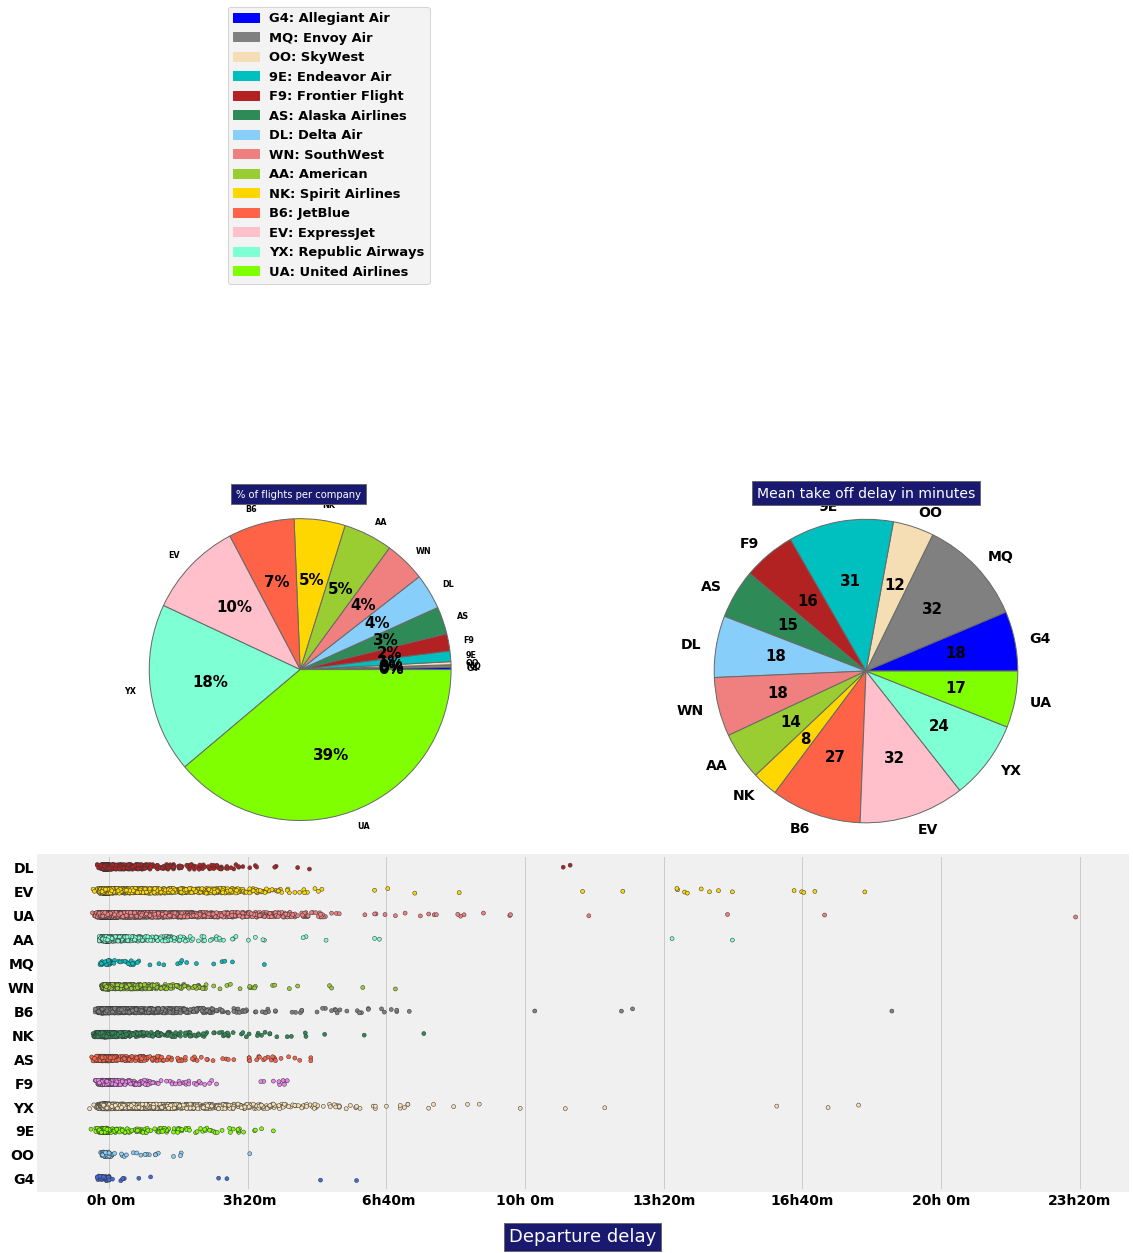

In [15]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['OP_UNIQUE_CARRIER', 'DEP_DELAY']]
#df2['OP_UNIQUE_CARRIER'] = df2['OP_UNIQUE_CARRIER'].replace(abbr_companies)
#________________________________________________________________________
colors = ['blue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'pink', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.0 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(8)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=10)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean take off delay in minutes', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=14)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="OP_UNIQUE_CARRIER", x="DEP_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

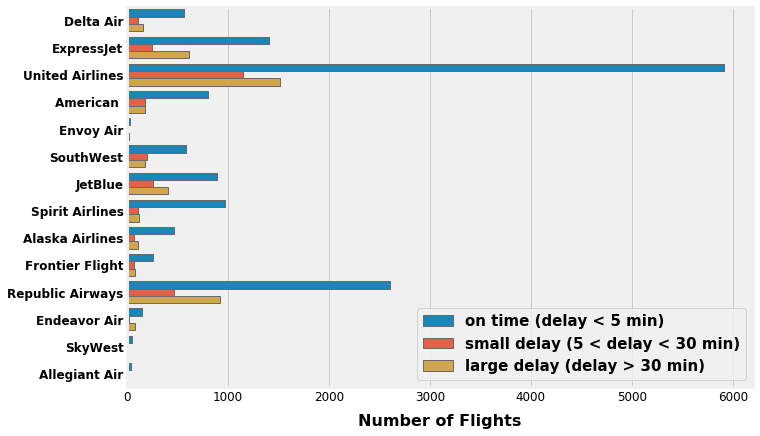

In [16]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 30]
df['DELAY_LEVEL'] = df['DEP_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="OP_UNIQUE_CARRIER", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Number of Flights', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (delay < 5 min)')
L.get_texts()[1].set_text('small delay (5 < delay < 30 min)')
L.get_texts()[2].set_text('large delay (delay > 30 min)')
plt.show()

ValueError: array must not contain infs or NaNs

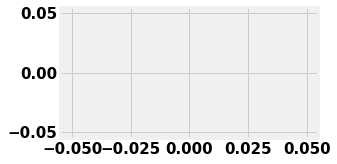

In [17]:
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(14,14))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['OP_UNIQUE_CARRIER']==carrier_name]['DEP_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 13:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

In [18]:
df.head()

,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAY_LEVEL
0,1,DL,370,ATL,EWR,-4.0,0,0.0,0.0,0.0,0.0,0.0,0
1,1,DL,384,ATL,EWR,4.0,0,0.0,0.0,0.0,0.0,0.0,0
2,1,DL,668,DTW,EWR,0.0,0,0.0,0.0,0.0,0.0,0.0,0
3,1,DL,690,EWR,DTW,-10.0,0,0.0,0.0,0.0,0.0,0.0,0
4,1,DL,807,EWR,ATL,-5.0,0,0.0,0.0,0.0,0.0,0.0,0


IndexError: list index out of range

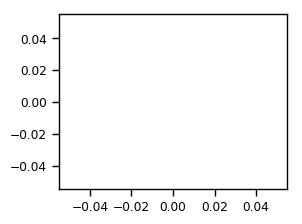

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

In [23]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['AIRPORT'].to_dict()

In [24]:
print("Nb of airports: {}".format(len(df['ORIGIN'].unique())))

Nb of airports: 89


In [25]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['OP_UNIQUE_CARRIER'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

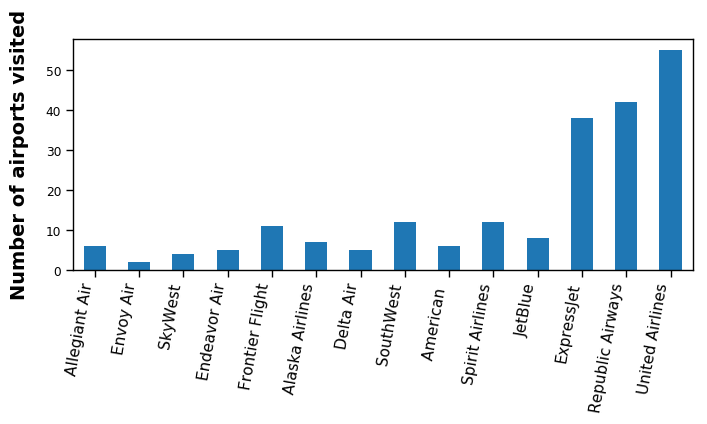

In [26]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()


In [27]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['OP_UNIQUE_CARRIER'] == carrier]
    test = df1['DEP_DELAY'].groupby(df['ORIGIN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

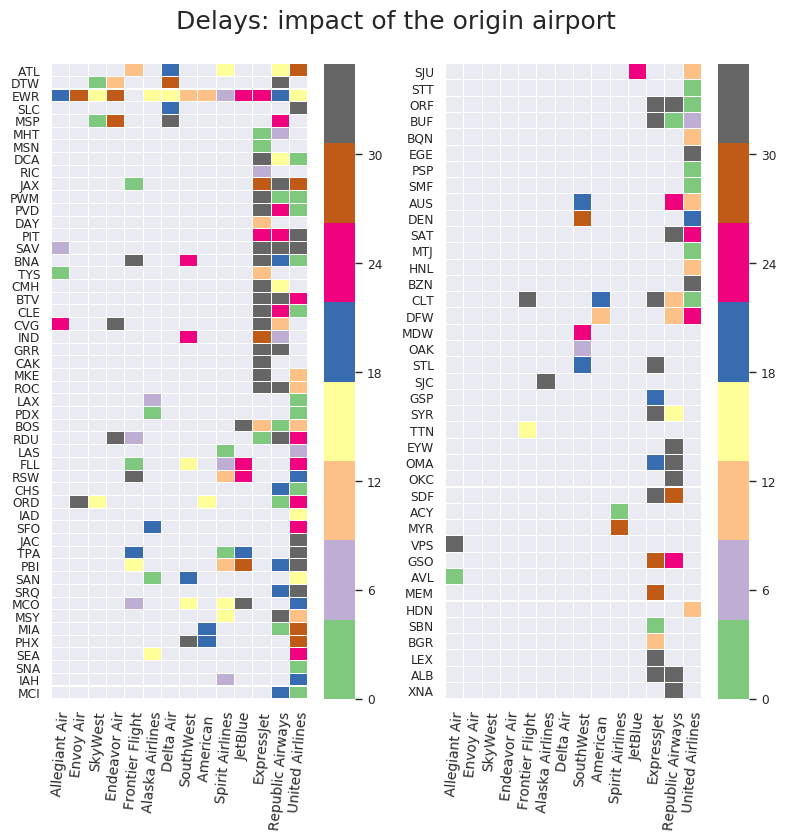

In [28]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
#subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
#subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

In [29]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'UA'
df1 = df[df['OP_UNIQUE_CARRIER']==carrier][['ORIGIN','DEST','DEP_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEP_DELAY']): continue
    route = str(col['ORIGIN'])+'-'+str(col['DEST'])
    if route in trajet.keys():
        trajet[route].append(col['DEP_DELAY'])
    else:
        trajet[route] = [col['DEP_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

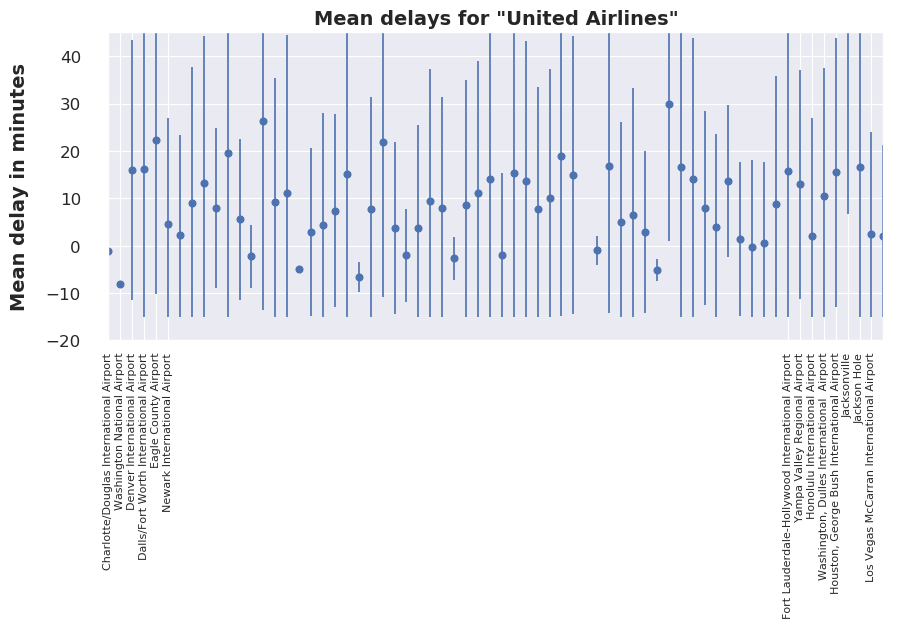

In [30]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay in minutes', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 10, 75
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

In [31]:
carrier = 'UA'
id_airport = 4
liste_origin_airport = df[df['OP_UNIQUE_CARRIER'] == carrier]['ORIGIN'].unique()
df2 = df[(df['OP_UNIQUE_CARRIER'] == carrier)
         & (df['ORIGIN'] == liste_origin_airport[id_airport])]

In [32]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])         

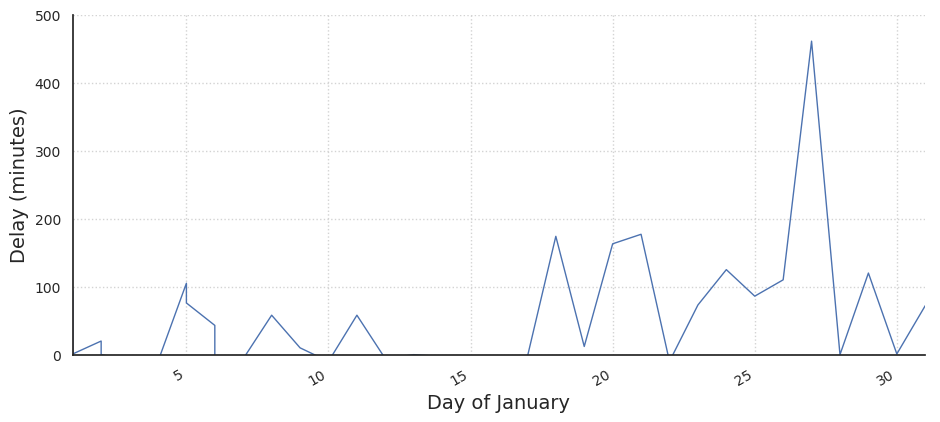

In [34]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['DAY_OF_MONTH'], df2['DEP_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Day of January', fontsize = 14)
fig1.set_xlim(1, 31)
fig1.set_ylim(0, 500)

In [50]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['DAY_OF_MONTH']
test2 = df2['DEP_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
x_val = df2['DAY_OF_MONTH']
y_val = test2['mean']
#popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
#test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

In [51]:
df_train = df['DAY_OF_MONTH']
df_test  = df['DAY_OF_MONTH']
dfTrained = df_train #TRAINED

In [65]:
#MODEL 1

carrier = 'DL'
check_airports = df[(df['OP_UNIQUE_CARRIER'] == carrier)]['DEP_DELAY'].groupby(
                         df['ORIGIN']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,count,max,mean,min
ORIGIN,,,,
EWR,415.0,655.0,14.289157,-17.0
ATL,277.0,211.0,19.025271,-15.0
DTW,58.0,289.0,29.172414,-8.0
MSP,51.0,665.0,36.960784,-10.0
SLC,29.0,151.0,21.758621,-7.0


In [66]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['OP_UNIQUE_CARRIER'] == carrier) & (df['ORIGIN'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEP_DELAY'] = df2['DEP_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('DAY_OF_MONTH', inplace = True)
    df2['heure_depart'] =  df2['DAY_OF_MONTH']
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEP_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x*3600+x*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart']
    return test2

In [67]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [68]:
id_airport = 'SFO'
df2 = df[(df['OP_UNIQUE_CARRIER'] == carrier) & (df['ORIGIN'] == id_airport)]
df2['heure_depart'] =  df2['DAY_OF_MONTH']
df2['heure_depart'] = df2['heure_depart']
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

AttributeError: 'Int64Index' object has no attribute 'remove_unused_levels'

In [70]:
dfTrained.head()

0    1
1    1
2    1
3    1
4    1
Name: DAY_OF_MONTH, dtype: int64

In [44]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    def predict(self, X):    
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)
        #neg_mean_squared_error ^

In [71]:
df.head()

,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,DL,370,ATL,EWR,-4.0,0,NaN,NaN,NaN,NaN,NaN
1,1,DL,384,ATL,EWR,4.0,0,NaN,NaN,NaN,NaN,NaN
2,1,DL,668,DTW,EWR,0.0,0,NaN,NaN,NaN,NaN,NaN
3,1,DL,690,EWR,DTW,-10.0,0,NaN,NaN,NaN,NaN,NaN
4,1,DL,807,EWR,ATL,-5.0,0,NaN,NaN,NaN,NaN,NaN


AttributeError: 'Int64Index' object has no attribute 'remove_unused_levels'

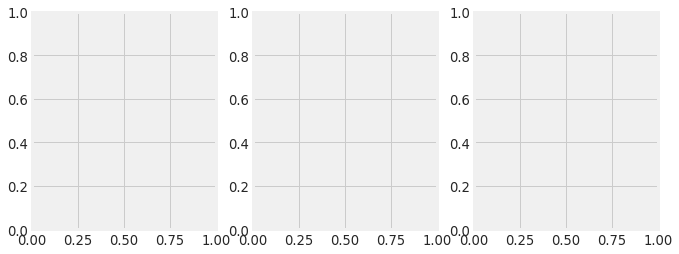

In [72]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}")
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break

In [59]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error')) #neg_mean_squared_error

In [60]:
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 30 



KeyError: "['heure_depart_min'] not in index"

In [62]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

KeyError: "['heure_depart_min'] not in index"

In [63]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

NameError: name 'fit2' is not defined

NameError: name 'fit2' is not defined

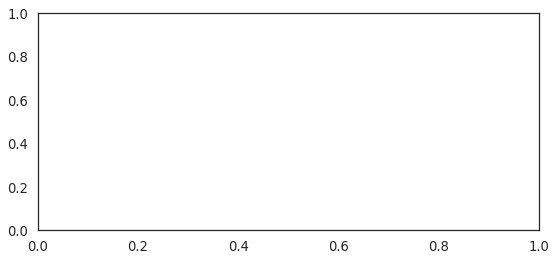

In [74]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [75]:
score = metrics.mean_squared_error(fit.result, fit2.Y) #neg_mean_squared_error
score

NameError: name 'fit' is not defined

In [76]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

KeyError: 'OP_UNIQUE_CARRIER'

In [79]:
#'Ecart = {:.2f} min'.format(np.sqrt(score))

In [105]:
# Model 2: One airport, all airlines

def get_merged_delays(df, carrier):
    liste_airports = df[df['OP_UNIQUE_CARRIER'] == carrier]['ORIGIN'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [80]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(184, 3)

In [81]:
# the merged_df dataframe, airports are referenced by an identifier given in the ORIGIN variable. 
#The corresponding labels can't be used directly in a fit and I thus use the one-hot-encoding method:

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'CLT'), (1, 'DFW'), (2, 'EWR'), (3, 'MIA'), (4, 'ORD')]

In [82]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(184, 7) (184, 1)


In [83]:
#Linear regression
#The matrices X and Y thus created can be used to perform a linear regression:

lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 80.93773531202457


In [84]:
#MSE score of the fit
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'7.61%'

AttributeError: module 'seaborn' has no attribute 'plt'

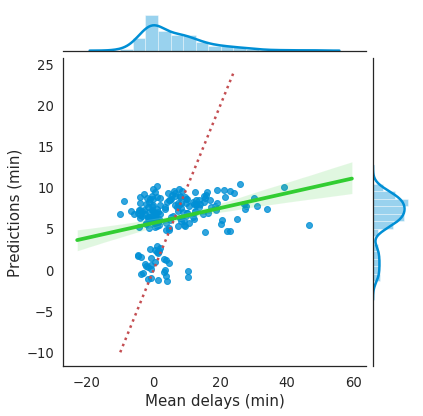

In [85]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

In [86]:
#Polynomial regression
#I will now extend the previous fit by using a polynomial rather than a linear function:

poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 75.46775494542068


In [88]:
#We can see that a polynomial fit improves slightly the MSE score. In practice, 
#the percentage of values where the difference between predictions and real delays is greater than 15 minutes is:

icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'7.61%'

AttributeError: module 'seaborn' has no attribute 'plt'

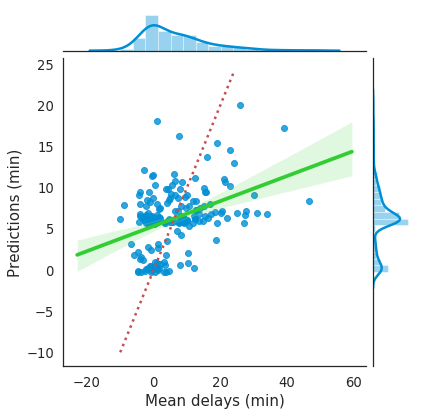

In [89]:
#And as before, it can be seen that model tends to be worse in the case of large delays:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

In [90]:
#5.2.3 Setting the free parameters
#Above, the two models were fit and tested on the training set. 
#In practice, as mentioned above, there is a risk of overfitting by proceeding that 
#way and the free parameters of the model will be biased. Hence, the model will not allow a good generalization. 
#In what follows, I will therefore split the datas in order to train and then test the model. 
#The purpose will be to determine the polynomial degree which allows the best generalization of the predictions:

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [92]:
X_train.shape

poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  61.43506729469156


In [93]:
#Testing on the test set:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  121.45978357215287


In [94]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

In [95]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [96]:
#Now, if we calculate the score associated to the predictions made with a regularization technique, we have:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  125.36934769527029


In [97]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 129.69
n=1 alpha=2 , MSE = 129.19
n=1 alpha=4 , MSE = 128.98
n=1 alpha=6 , MSE = 128.92
n=1 alpha=8 , MSE = 128.94
n=1 alpha=10 , MSE = 129.0
n=1 alpha=12 , MSE = 129.07
n=1 alpha=14 , MSE = 129.16
n=1 alpha=16 , MSE = 129.25
n=1 alpha=18 , MSE = 129.34
n=2 alpha=0 , MSE = 121.46
n=2 alpha=2 , MSE = 124.83
n=2 alpha=4 , MSE = 125.72
n=2 alpha=6 , MSE = 126.17
n=2 alpha=8 , MSE = 126.44
n=2 alpha=10 , MSE = 126.63
n=2 alpha=12 , MSE = 126.79
n=2 alpha=14 , MSE = 126.92
n=2 alpha=16 , MSE = 127.04
n=2 alpha=18 , MSE = 127.15


In [98]:
#This grid search allows to find the best set of  α  and  n  parameters. 
#Let us note, however, that for this model, the estimates obtained with a 
#linear regression or a polynomial of order 2 are quite close. 
#Now I use these parameters to test this template over the test set:

ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

75.95269071659521


In [99]:
#Testing the model: delays of end-january
#At this stage, model predictions are tested against end-January data. These data are first extracted:

In [106]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

KeyError: 'OP_UNIQUE_CARRIER'

In [107]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

NameError: name 'merged_df_test' is not defined

In [108]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

'MSE = 97.85'

In [109]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 9.89 min'

In [110]:
#6.3 Model nº3: Accounting for destinations

#NOTES FOR TOMORROW: 
#KNOW THE AMOUNT OF AND NAMES OF MODELS.
#KNOW WHAT TYPE OF REGRESSION IS ACTUALLY USED - POLYNOMIAL?

In [111]:
#ATTEMPTING TO MAKE A SCATTERPLOT


In [112]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set()

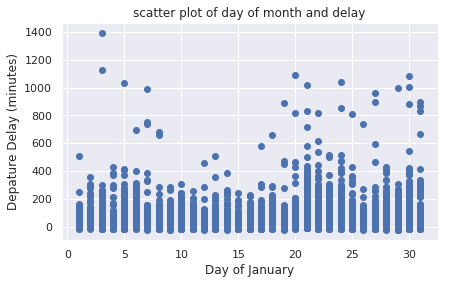

In [129]:
xScat = df['DAY_OF_MONTH']
yScat =  df['DEP_DELAY']
plt.scatter(xScat,yScat)
plt.title('scatter plot of day of month and delay')
plt.xlabel('Day of January', fontsize=12)
plt.ylabel('Depature Delay (minutes)', fontsize=12);
plt.show()

In [138]:
#DO SAME BUT WITH AIRLINE

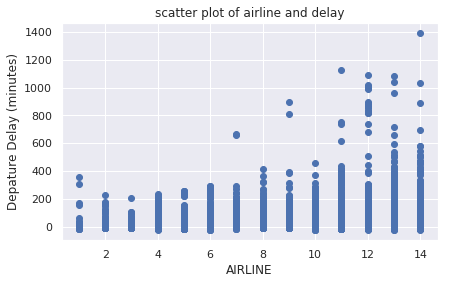

In [137]:
dfBINARY = pd.read_csv('flightDataBINARY.csv', low_memory=False)

xScatAL = dfBINARY['OP_UNIQUE_CARRIER']
yScatAL =  dfBINARY['DEP_DELAY']
plt.scatter(xScatAL,yScatAL)
plt.title('scatter plot of airline and delay')
plt.xlabel('AIRLINE', fontsize=12)
plt.ylabel('Depature Delay (minutes)', fontsize=12);
plt.show()